In [1]:
library(car)
library(dplyr)
library(ggplot2)
library(ROCR)
library(pROC)
library(stargazer)

Loading required package: carData


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 




In [3]:
df <- read.csv('covid_county.csv')

Some cleaning...

In [4]:
# convert to date format
df$stay_home_date <- as.Date(df$stay_home_date)
df$first_case <- as.Date(df$first_case)

# create exposure days variable, the number of days after the first case in which no lockdown was in place
# if there is no order, final data of the data set minus first case. If there is, order date minus first case
df$exp_days <- ifelse(is.na(df$stay_home_date), as.Date('2020-04-26') - df$first_case, df$stay_home_date - df$first_case)
df$exp_days[df$exp_days < 0] <- 0

df$adjexp_days <- ifelse(is.na(df$stay_home_date), as.Date('2020-04-26') - as.Date('2020-03-16'), df$stay_home_date - as.Date('2020-03-16'))

# create deaths percent
df$dpc <- df$deaths/df$pop2018

# create cases percent
df$cpc <- df$cases/df$pop2018

# % elderly
df$eld_perc <- df$over652018/df$pop2018

# republican majority binary
df$rmaj <- ifelse(df$r_percent > df$d_percent, 1, 0)
df$dmaj <- ifelse(df$d_percent > df$r_percent, 1, 0)

# days since first case
df$since_first <- as.Date('2020-04-26')-df$first_case

# distance between when a county had its first stay at home order and when federal stay at home guidelines were issued
df$dist_from_stayhome <- df$first_case - as.Date('2020-03-16')

# dummy for whether a stay at home order was issued
df$stayhome_issued <- ifelse(!is.na(df$stay_home_date), 1, 0)

# H1: Stay home order issued

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = stayhome_issued ~ r_percent + dpc + eld_perc + 
    dens2019, family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3919   0.2261   0.5723   0.6862   0.9649  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.646e+00  3.547e-01   4.641 3.47e-06 ***
r_percent   -1.571e-02  3.923e-03  -4.005 6.20e-05 ***
dpc          2.204e+02  6.839e+01   3.223  0.00127 ** 
eld_perc     2.784e+00  1.171e+00   2.376  0.01749 *  
dens2019     4.795e-03  7.511e-04   6.385 1.72e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2771.0  on 3061  degrees of freedom
Residual deviance: 2590.5  on 3057  degrees of freedom
  (80 observations deleted due to missingness)
AIC: 2600.5

Number of Fisher Scoring iterations: 8


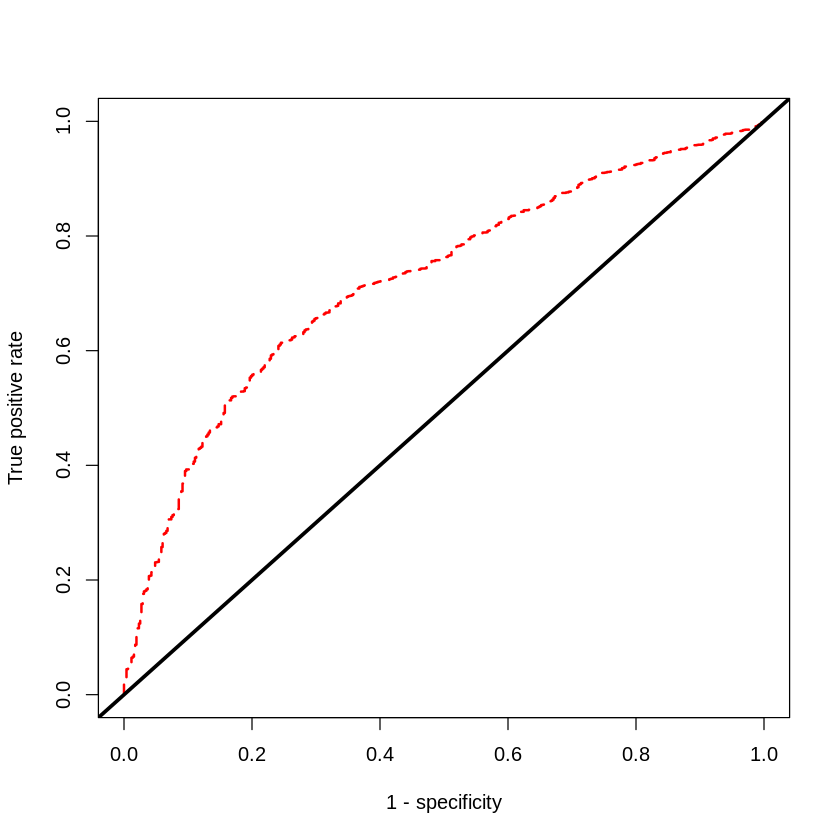

In [5]:
# Model 1
home1 <- glm(stayhome_issued ~ r_percent + dpc + eld_perc + dens2019, data = df, family=binomial(link="logit"))
summary(home1)


# subset to complete cases
logdf <- df[,c('dpc', 'eld_perc', 'dens2019', 'r_percent', 'stayhome_issued')]
logdf <- logdf[complete.cases(logdf),]

# ROC curve
home1.hats <- predict(home1, type = "response")
# get predictions 
preds1 <- prediction(home1.hats, logdf$stayhome_issued)

#plot
plot(performance(preds1, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = stayhome_issued ~ r_percent + dpc + cpc + eld_perc + 
    dens2019, family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.3969   0.2265   0.5717   0.6850   0.9585  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.716e+00  3.650e-01   4.700 2.60e-06 ***
r_percent   -1.619e-02  3.971e-03  -4.078 4.53e-05 ***
dpc          2.444e+02  7.473e+01   3.271  0.00107 ** 
cpc         -1.887e+00  2.270e+00  -0.831  0.40584    
eld_perc     2.687e+00  1.177e+00   2.282  0.02247 *  
dens2019     4.800e-03  7.501e-04   6.399 1.56e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2771.0  on 3061  degrees of freedom
Residual deviance: 2589.8  on 3056  degrees of freedom
  (80 observations deleted due to missingness)
AIC: 2601.8

Number of Fisher Scoring iterations: 8


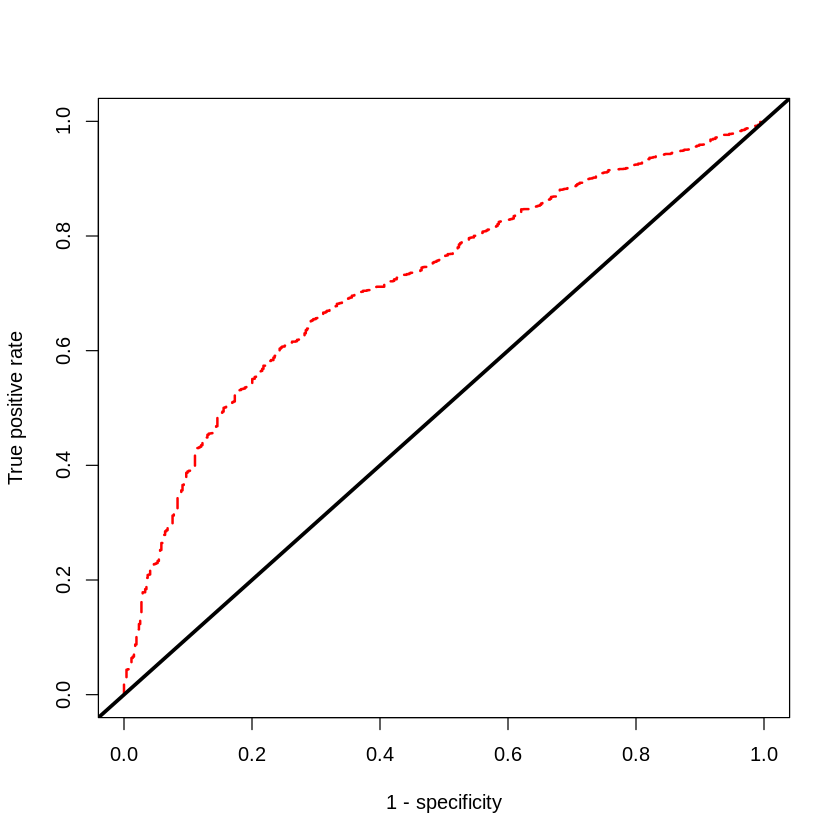

In [6]:
# Model 1A
home1c <- glm(stayhome_issued ~ r_percent + dpc + cpc + eld_perc + dens2019, data = df, family=binomial(link="logit"))
summary(home1c)


# subset to complete cases
logdf <- df[,c('dpc', 'cpc', 'eld_perc', 'dens2019', 'r_percent', 'stayhome_issued')]
logdf <- logdf[complete.cases(logdf),]

# ROC curve
home1c.hats <- predict(home1c, type = "response")
# get predictions 
preds <- prediction(home1c.hats, logdf$stayhome_issued)

#plot
plot(performance(preds, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

In [116]:
# get the area under the curve
homeroc <- roc(logdf$stayhome_issued, home1.hats, ci=TRUE)
m1auc <- auc(homeroc)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



In [143]:
# Model 1 Confusion Matrix
table(home1$fitted.values>0.5,logdf$stayhome_issued == 1)

      
       FALSE TRUE
  TRUE   514 2548


Call:
glm(formula = stayhome_issued ~ r_percent + log(deaths + 1e-06) + 
    log(over652018) + log(pop2018), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7114   0.2828   0.4793   0.6488   2.1473  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.823256   0.672485  -1.224 0.220877    
r_percent           -0.008436   0.003940  -2.141 0.032261 *  
log(deaths + 1e-06)  0.026398   0.007734   3.413 0.000642 ***
log(over652018)      1.276178   0.238191   5.358 8.42e-08 ***
log(pop2018)        -0.739853   0.224541  -3.295 0.000984 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2773.2  on 3067  degrees of freedom
Residual deviance: 2505.8  on 3063  degrees of freedom
  (74 observations deleted due to missingness)
AIC: 2515.8

Number of Fisher Scoring iterations: 5


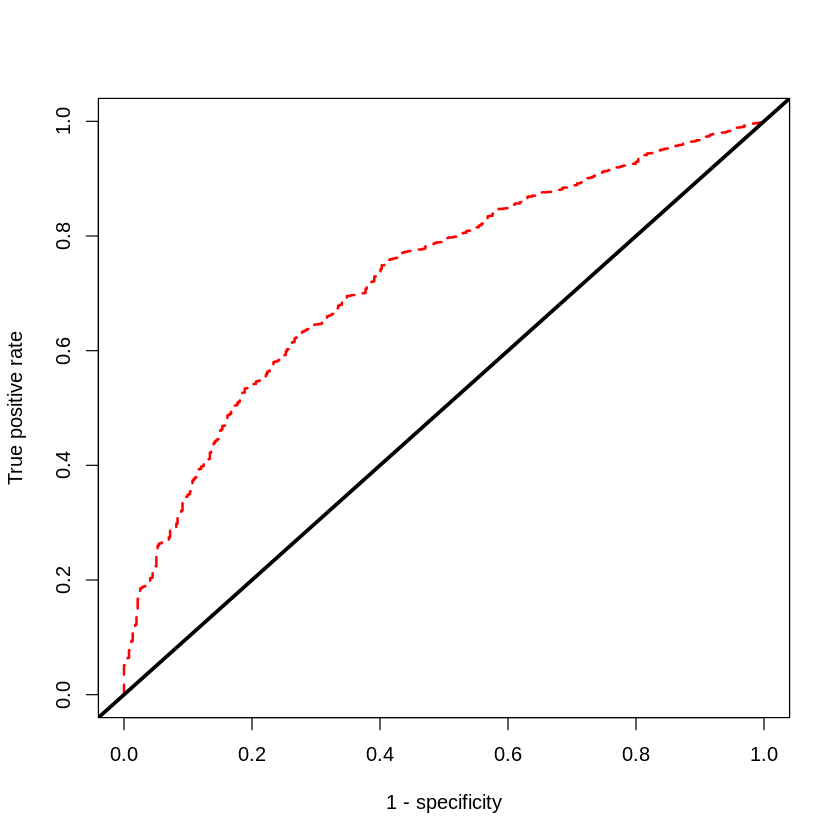

In [10]:
# Model 2
home2 <- glm(stayhome_issued ~ r_percent + log(deaths + .000001) + log(over652018) + log(pop2018),  data = df, family=binomial(link="logit"))
summary(home2)


# subset to complete cases
logdf2 <- df[,c('deaths', 'over652018', 'pop2018', 'r_percent', 'stayhome_issued')]
logdf2 <- logdf2[complete.cases(logdf2),]

# ROC curve
home2.hats <- predict(home2, type = "response")
# get predictions 
preds2 <- prediction(home2.hats, logdf2$stayhome_issued)

#plot
plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

In [144]:
# Confusion Matrix
table(home2$fitted.values>0.5,logdf2$stayhome_issued == 1)

       
        FALSE TRUE
  FALSE    16   19
  TRUE    498 2535

In [147]:
# VIF
vif(home2)
vif(home1)

r_percent log(deaths + 1e-06)     log(over652018)        log(pop2018) 
           1.177275            1.266943           30.109616           31.046428

r_percent       dpc  eld_perc  dens2019 
 1.068792  1.029573  1.099449  1.136784


Call:
glm(formula = stayhome_issued ~ r_percent + log(deaths + 1e-06) + 
    log(cases + 1e-06) + log(over652018) + log(pop2018), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7174   0.2812   0.4790   0.6471   2.1452  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.886344   0.715918  -1.238 0.215696    
r_percent           -0.008506   0.003948  -2.154 0.031216 *  
log(deaths + 1e-06)  0.026635   0.007785   3.421 0.000623 ***
log(cases + 1e-06)  -0.002327   0.009099  -0.256 0.798137    
log(over652018)      1.271871   0.238764   5.327 9.99e-08 ***
log(pop2018)        -0.728526   0.228831  -3.184 0.001454 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2773.2  on 3067  degrees of freedom
Residual deviance: 2505.8  on 3062  degrees of freedom
  (74 observations 

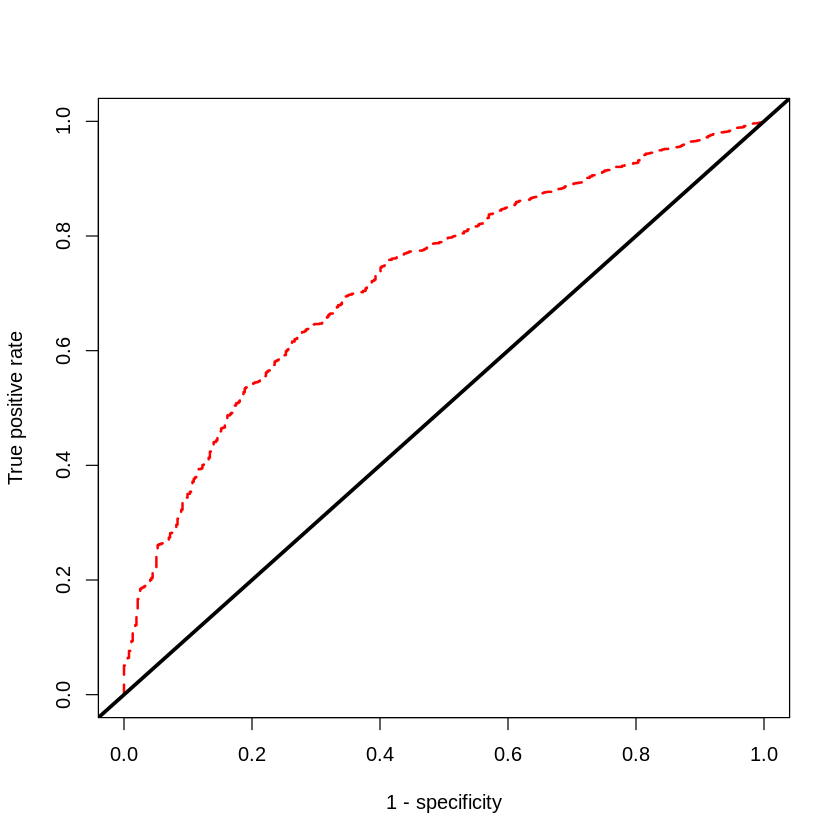

In [11]:
# Model 2A
home2c <- glm(stayhome_issued ~ r_percent + log(deaths + .000001) + log(cases + .000001) + log(over652018) + log(pop2018),  data = df, family=binomial(link="logit"))
summary(home2c)


# subset to complete cases
logdf2 <- df[,c('deaths', 'cases', 'over652018', 'pop2018', 'r_percent', 'stayhome_issued')]
logdf2 <- logdf2[complete.cases(logdf2),]

# ROC curve
home2c.hats <- predict(home2c, type = "response")
# get predictions 
preds2 <- prediction(home2c.hats, logdf2$stayhome_issued)

#plot
plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', xlab='1 - specificity', yalb='sensitivity')
abline(a=0,b=1,lwd=3)

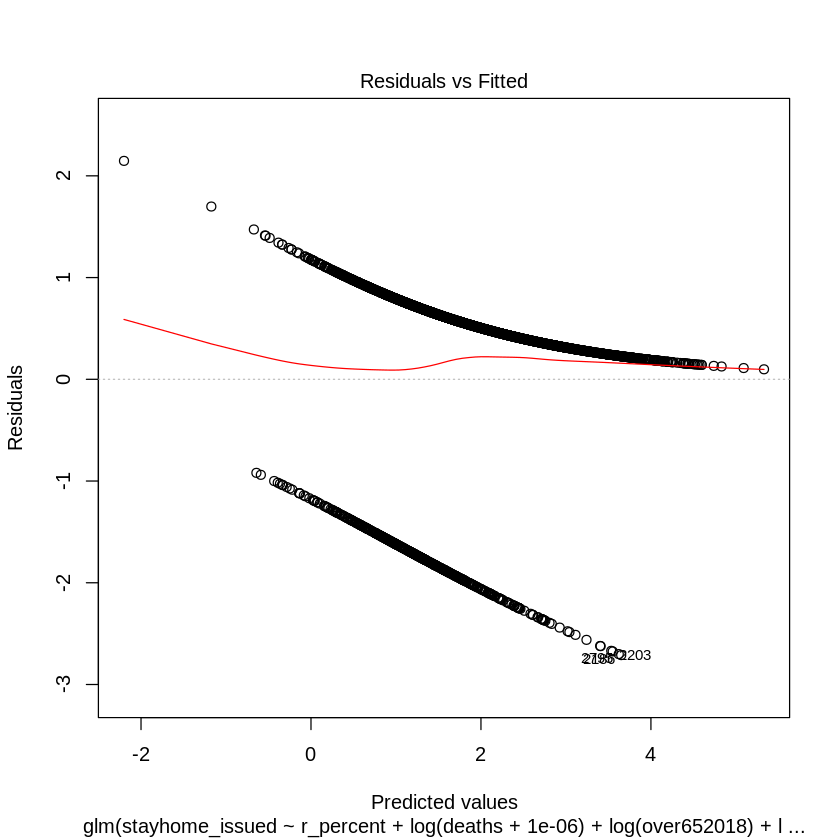

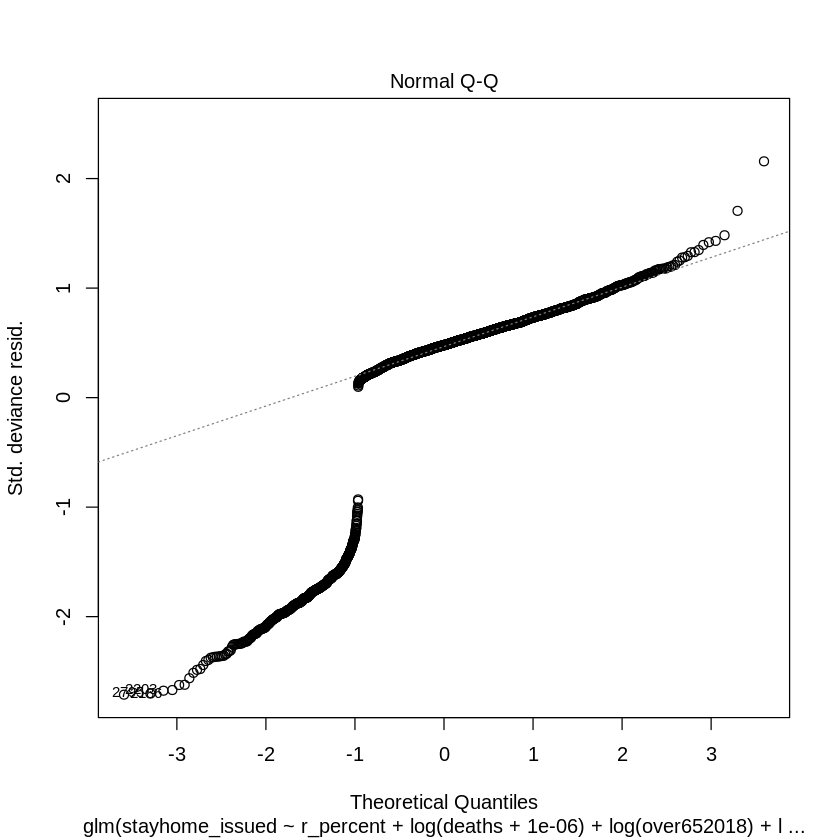

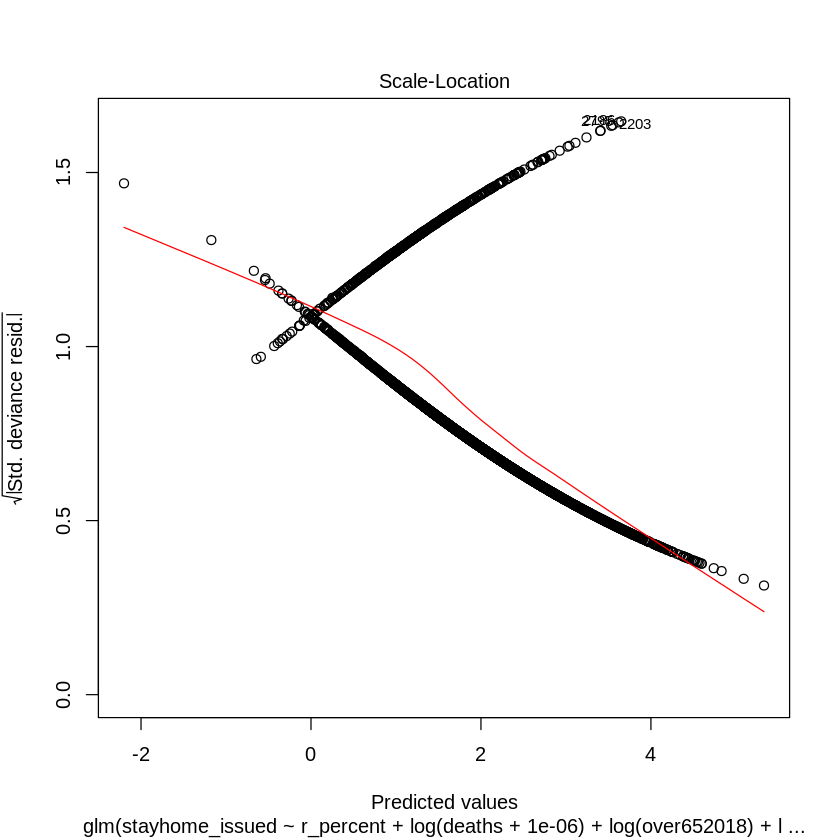

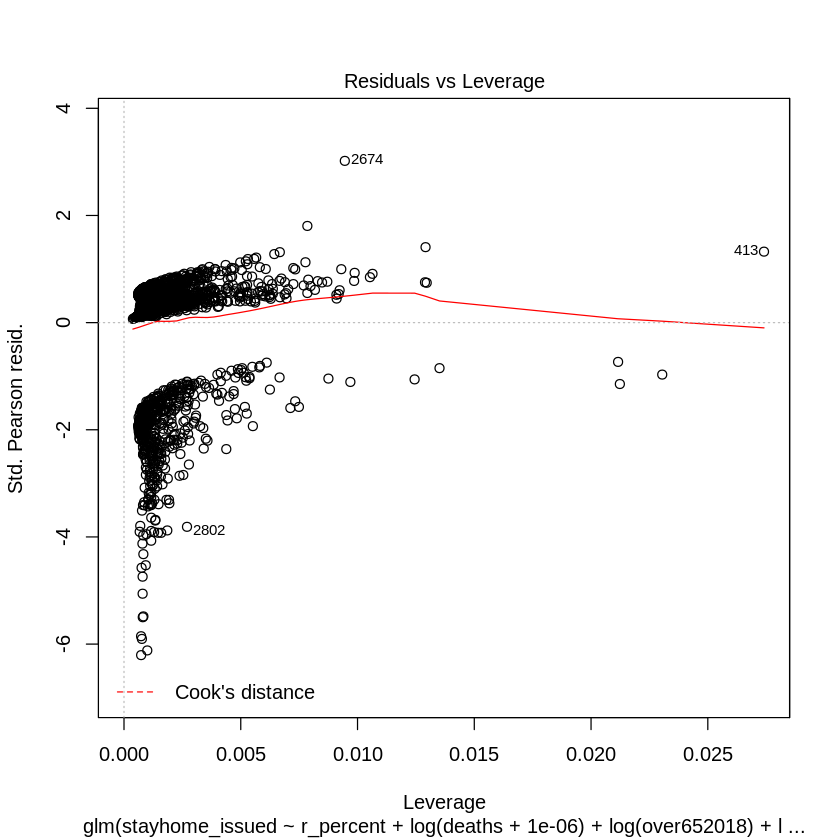

In [14]:
plot(home2)

In [82]:
# H1 Regression Table
stargazer(home1, home1c, home2, home2c, type = 'latex', title = 'H1 Logistic Regression',
          dep.var.labels = c('Stayhome Order Issued'),
          column.labels = c('Model 1', 'Model 1A', 'Model 2', 'Model 2A'),
          align=TRUE, 
          covariate.labels = c('R Vote Perc.', 'Perc. Killed', 'Perc. Infected', 'Perc. Over 65', 'Pop. Density', 'log(Deaths)', 'log(Cases)', 'log(Over 65)', 'log(Pop)', 'Constant'),
          no.space = FALSE)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, May 04, 2020 - 04:38:42 PM
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{H1 Logistic Regression} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} D{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{4}{c}{Stayhome Order Issued} \\ 
 & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 1A} & \multicolumn{1}{c}{Model2} & \multicolumn{1}{c}{Model2A} \\ 
\\[-1.8ex] & \multicolumn{1}{c}{(1)} & \multicolumn{1}{c}{(2)} & \multicolumn{1}{c}{(3)} & \multicolumn{1}{c}{(4)}\\ 
\hline \\[-1.8ex] 
 R Vote Perc. & -0.016^{***} & -0.016^{***} & -0.008^{**} & -0.009^{**} \\ 
  & (0.004) & (0.004) & (0.004) & (0.004) \\ 
  & & & & \\ 
 Perc. Killed & 220.399^{***} & 244.439^{***} &  &  \\ 
  & (68.390) & (74

In [134]:
# Plot and save the ROC curves
png(file="./plots/ROC1.png",
width=350, height=350)

plot(performance(preds1, "tpr", "fpr"), lwd=2, lty=2, col='red',
     xlab='1 - specificity', 
     yalb='sensitivity', 
     main = 'ROC Curve Model 1',
     sub = paste('AUC: ', toString(round(m1auc, 3))))
abline(a=0,b=1,lwd=3)

dev.off()

png(file="./plots/ROC2.png",
width=350, height=350)

plot(performance(preds2, "tpr", "fpr"), lwd=2, lty=2, col='red', 
     xlab='1 - specificity', 
     yalb='sensitivity', 
     main = 'ROC Curve Model 2',
     sub = paste('AUC: ', toString(round(m2auc, 3))))
abline(a=0,b=1,lwd=3)

dev.off()

png 
  2

png 
  2

# H2: Exposure Days

In [295]:
# Model 3
exp1 <- lm(exp_days ~  r_percent + eld_perc  + dens2019 + since_first, data = df)
summary(exp1)

vif(exp1)


Call:
lm(formula = exp_days ~ r_percent + eld_perc + dens2019 + since_first, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-13.150  -6.843  -3.013   2.438  38.802 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -7.656e+00  1.593e+00  -4.807 1.62e-06 ***
r_percent    4.745e-02  1.419e-02   3.345 0.000835 ***
eld_perc    -1.416e+01  4.490e+00  -3.154 0.001626 ** 
dens2019    -3.270e-05  1.049e-04  -0.312 0.755352    
since_first  5.441e-01  2.025e-02  26.868  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.934 on 2743 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.2545,	Adjusted R-squared:  0.2534 
F-statistic: 234.1 on 4 and 2743 DF,  p-value: < 2.2e-16


r_percent    eld_perc    dens2019 since_first 
   1.295930    1.110146    1.074811    1.334775

In [291]:
# Model 3A
exp1a <- lm(exp_days ~  r_percent + eld_perc  + dens2019 + since_first, data = df[df$stayhome_issued == 1,])
summary(exp1a)

vif(exp1a)


Call:
lm(formula = exp_days ~ r_percent + eld_perc + dens2019 + since_first, 
    data = df[df$stayhome_issued == 1, ])

Residuals:
   Min     1Q Median     3Q    Max 
-9.635 -4.031 -0.380  3.230 32.169 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.044e+01  9.093e-01 -11.478   <2e-16 ***
r_percent   -1.084e-02  7.916e-03  -1.369    0.171    
eld_perc    -3.858e+00  2.514e+00  -1.535    0.125    
dens2019     5.018e-05  5.529e-05   0.908    0.364    
since_first  5.709e-01  1.177e-02  48.510   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.214 on 2328 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.588,	Adjusted R-squared:  0.5873 
F-statistic: 830.6 on 4 and 2328 DF,  p-value: < 2.2e-16


r_percent    eld_perc    dens2019 since_first 
   1.301116    1.099444    1.079031    1.342978

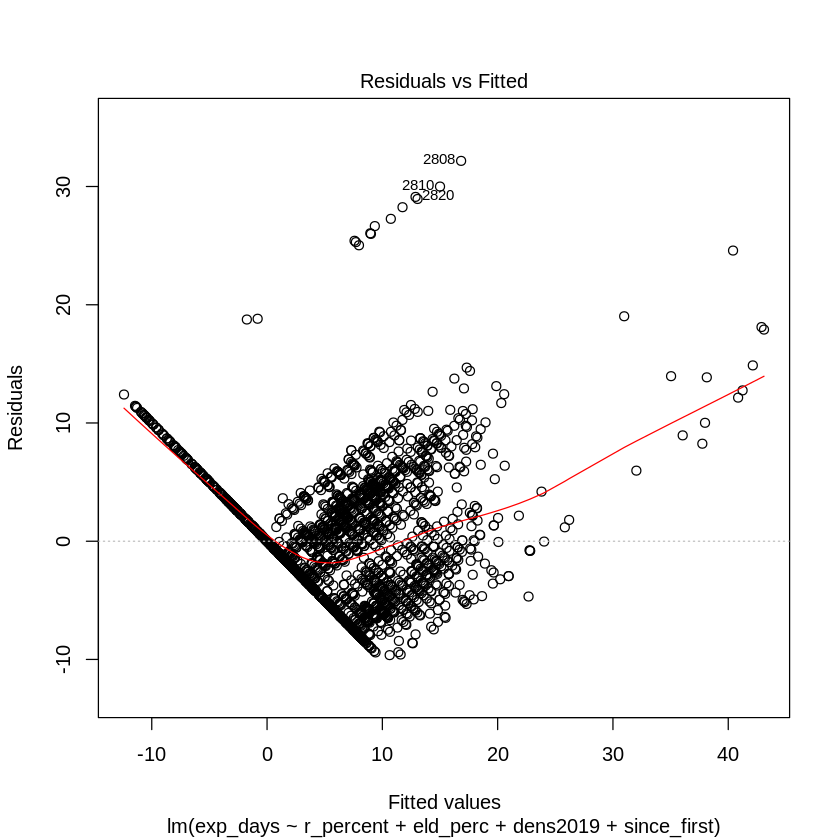

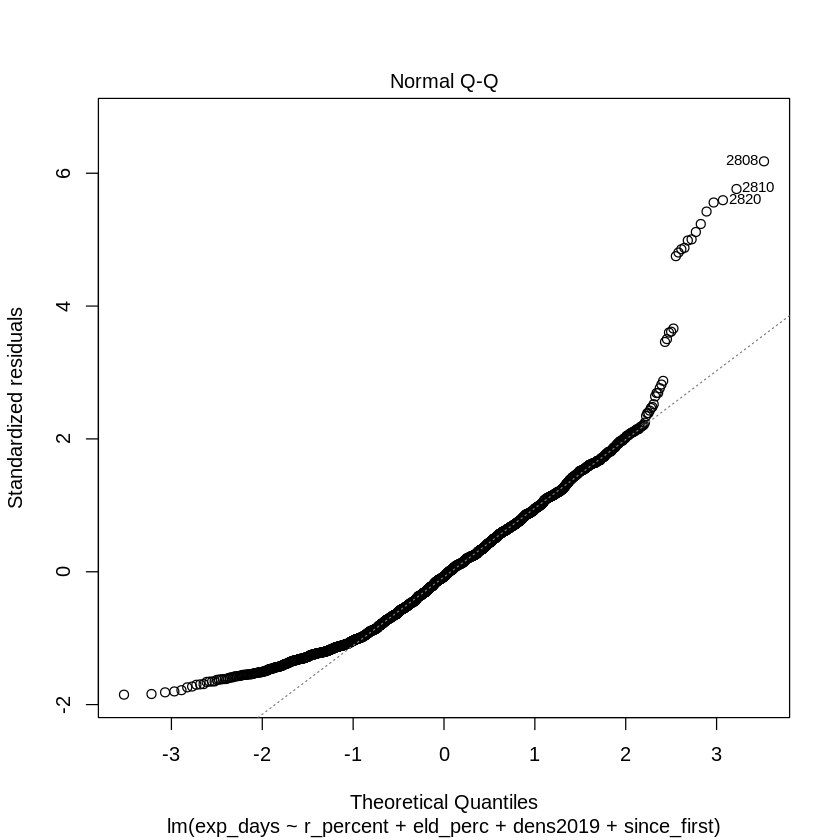

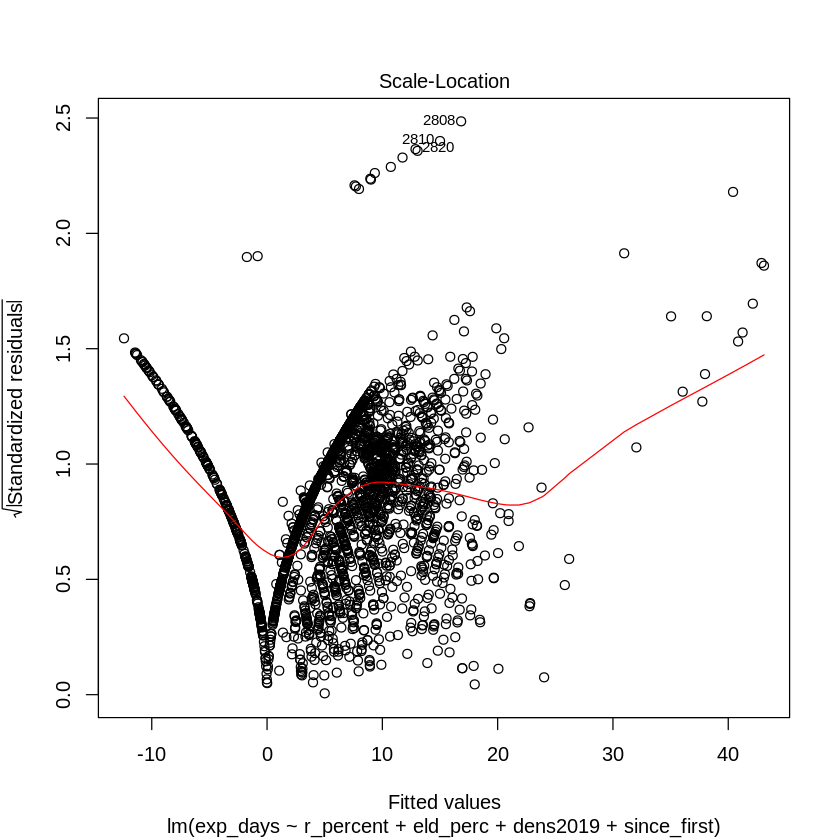

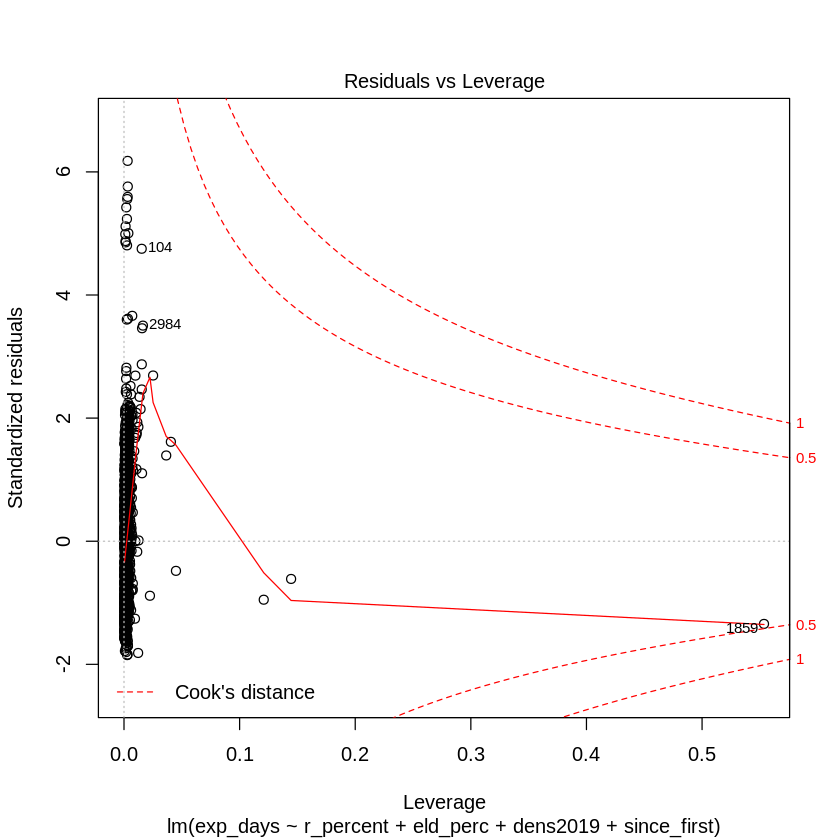

In [292]:
plot(exp1a)

In [216]:
# Model 4
exp2 <- lm(adjexp_days ~ r_percent + eld_perc + dens2019 + dist_from_stayhome,  data = df)
summary(exp2)

vif(exp2)


Call:
lm(formula = adjexp_days ~ eld_perc + dens2019 + dist_from_stayhome + 
    r_percent, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-16.310  -8.279  -2.618   2.516  29.904 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.318e+01  1.276e+00  10.328  < 2e-16 ***
eld_perc           -1.913e+01  5.093e+00  -3.756 0.000176 ***
dens2019           -1.788e-04  1.190e-04  -1.502 0.133283    
dist_from_stayhome  1.324e-01  2.297e-02   5.763 9.19e-09 ***
r_percent           9.506e-02  1.609e-02   5.906 3.93e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.27 on 2743 degrees of freedom
  (394 observations deleted due to missingness)
Multiple R-squared:  0.04467,	Adjusted R-squared:  0.04328 
F-statistic: 32.06 on 4 and 2743 DF,  p-value: < 2.2e-16


eld_perc           dens2019 dist_from_stayhome          r_percent 
          1.110146           1.074811           1.334775           1.295930

In [293]:
# Model 4A
exp2a <- lm(adjexp_days ~ r_percent + eld_perc + dens2019 + dist_from_stayhome, data = df[df$stayhome_issued == 1,])
summary(exp2a)

vif(exp2a)


Call:
lm(formula = adjexp_days ~ r_percent + eld_perc + dens2019 + 
    dist_from_stayhome, data = df[df$stayhome_issued == 1, ])

Residuals:
   Min     1Q Median     3Q    Max 
-9.804 -4.680 -0.497  4.436 29.553 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         1.116e+01  6.835e-01  16.334  < 2e-16 ***
r_percent           4.331e-02  8.544e-03   5.069 4.31e-07 ***
eld_perc           -8.341e+00  2.713e+00  -3.074  0.00214 ** 
dens2019           -1.367e-04  5.968e-05  -2.291  0.02206 *  
dist_from_stayhome  1.524e-02  1.270e-02   1.200  0.23023    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.628 on 2328 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.02318,	Adjusted R-squared:  0.02151 
F-statistic: 13.81 on 4 and 2328 DF,  p-value: 3.878e-11


r_percent           eld_perc           dens2019 dist_from_stayhome 
          1.301116           1.099444           1.079031           1.342978

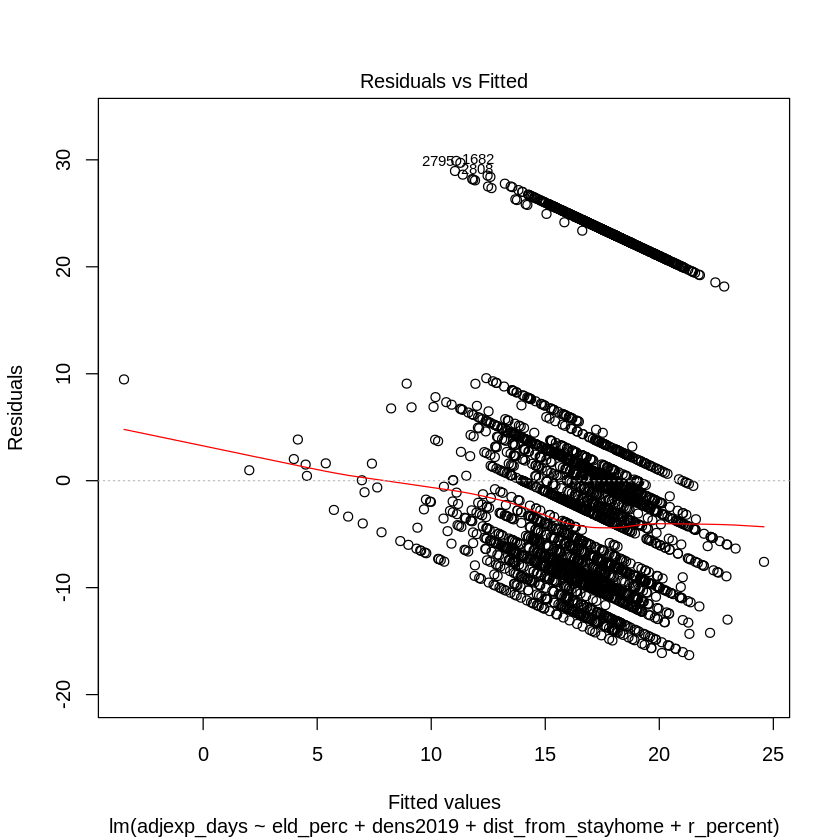

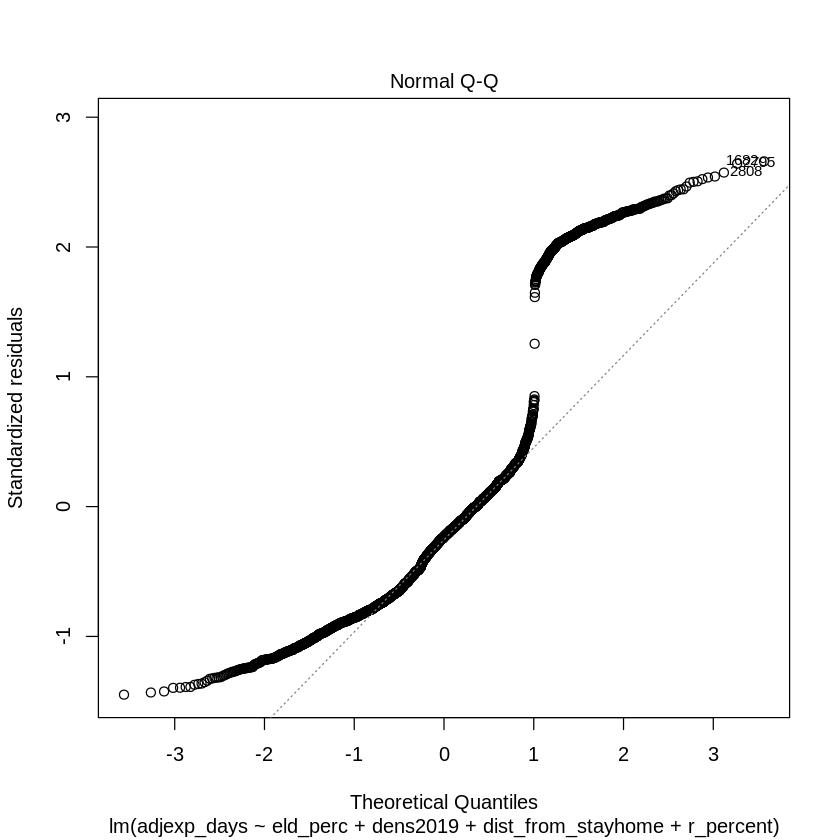

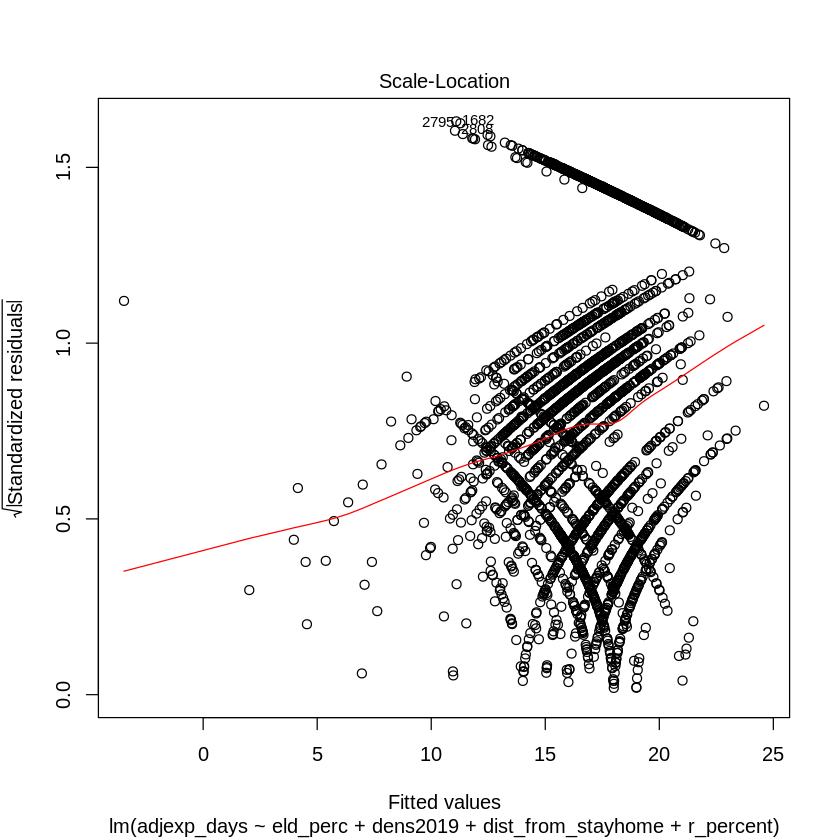

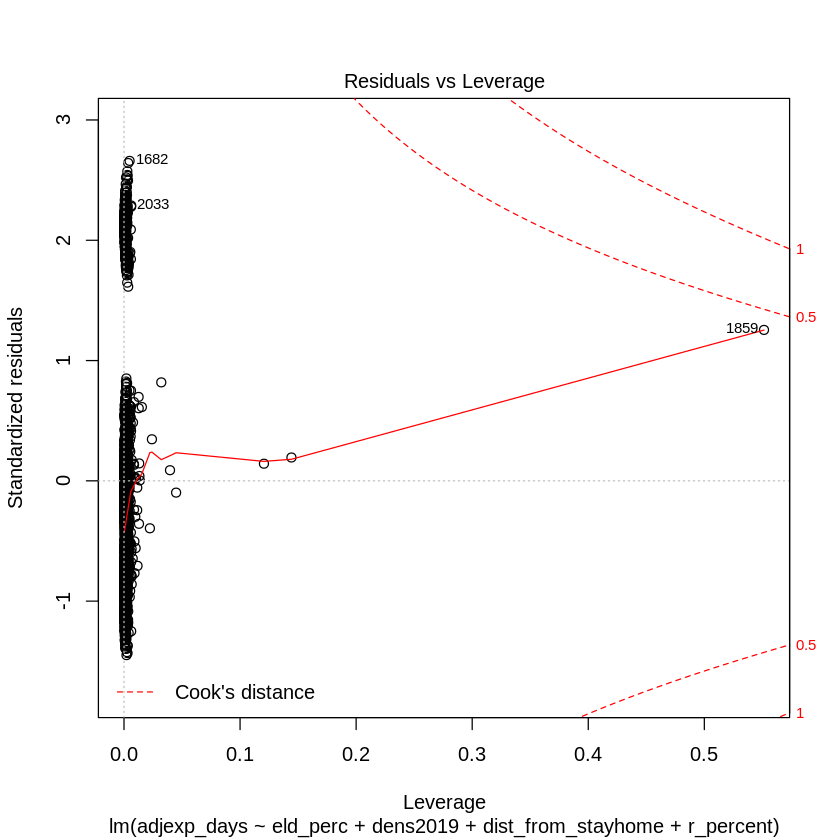

In [294]:
plot(exp2)

In [289]:
# Model 4A with interaction
exp2A <- lm(adjexp_days ~ r_percent + eld_perc + dens2019 + dist_from_stayhome + r_percent*dist_from_stayhome, data = df[df$stayhome_issued == 1,])
summary(exp2A)

vif(exp2A)


Call:
lm(formula = adjexp_days ~ r_percent + eld_perc + dens2019 + 
    dist_from_stayhome + r_percent * dist_from_stayhome, data = df[df$stayhome_issued == 
    1, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9699 -4.7198 -0.5024  4.4397 29.8114 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1.059e+01  7.101e-01  14.917  < 2e-16 ***
r_percent                     5.587e-02  9.561e-03   5.843 5.84e-09 ***
eld_perc                     -8.537e+00  2.710e+00  -3.150  0.00165 ** 
dens2019                     -8.920e-05  6.178e-05  -1.444  0.14892    
dist_from_stayhome            1.136e-01  3.613e-02   3.145  0.00168 ** 
r_percent:dist_from_stayhome -1.697e-03  5.837e-04  -2.908  0.00368 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.619 on 2327 degrees of freedom
  (294 observations deleted due to missingness)
Multiple R-squared:  0.02672,	Adjusted R-squ

r_percent                     eld_perc 
                    1.634421                     1.100120 
                    dens2019           dist_from_stayhome 
                    1.160182                    10.902300 
r_percent:dist_from_stayhome 
                   12.088540

In [327]:
# Residual and quantile plots for H2
png(file="./plots/exp1a_resid.png",
width=350, height=350)
plot(exp1a, which = 1)
dev.off()

png(file="./plots/exp1a_qq.png",
width=350, height=350)
plot(exp1a, which = 2)
dev.off()

png(file="./plots/exp2a_resid.png",
width=350, height=350)
plot(exp2a, which = 1)
dev.off()

png(file="./plots/exp2a_qq.png",
width=350, height=350)
plot(exp2a, which = 2)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

In [304]:
# H2 Regression Table
stargazer(exp1, exp1a, exp2, exp2a, type = 'latex', title = 'H2 Linear Regression',
          dep.var.labels = c('Exposure Days', 'Adjusted Exposure Days'),
          column.labels = c('Model 3', 'Model 3A', 'Model 4', 'Model 4A'),
          covariate.labels = c('R Vote Perc.', 'Perc. Over 65', 'Pop. Density', 'Days Since 1st Case', 'Adj. Days Since 1st Cast', 'Constant'),
          no.space = FALSE,
          omit.stat = c('f'))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, May 04, 2020 - 11:06:30 PM
\begin{table}[!htbp] \centering 
  \caption{H2 Linear Regression} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{2}{c}{Exposure Days} & \multicolumn{2}{c}{Adjusted Exposure Days} \\ 
 & Model 3 & Model 3A & Model 4 & Model 4A \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 R Vote Perc. & 0.047$^{***}$ & $-$0.011 & 0.095$^{***}$ & 0.043$^{***}$ \\ 
  & (0.014) & (0.008) & (0.016) & (0.009) \\ 
  & & & & \\ 
 Perc. Over 65 & $-$14.162$^{***}$ & $-$3.858 & $-$19.132$^{***}$ & $-$8.341$^{***}$ \\ 
  & (4.490) & (2.514) & (5.093) & (2.713) \\ 
  & & & & \\ 
 Pop. Density & $-$0.00003 & 0.0001 & $-$0.0002 & $-$0.0001$^{**}$ \\ 
  & (0.0001) & (0.0001) & (0.0001) & (0.0001) \\ 
  & & 

# H3: Deaths

In [29]:
# Model 5
d1 <- lm(dpc ~ r_percent + cpc + eld_perc + dens2019 + obesity + exp_days + stayhome_issued + since_first,  data = df[df$deaths >= 0,])
summary(d1)

vif(d1)


Call:
lm(formula = dpc ~ r_percent + cpc + eld_perc + dens2019 + obesity + 
    exp_days + stayhome_issued + since_first, data = df[df$deaths >= 
    0, ])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0178121 -0.0004036 -0.0001330  0.0001675  0.0241375 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -2.105e-03  3.568e-04  -5.899 4.11e-09 ***
r_percent       -4.919e-06  2.229e-06  -2.206  0.02744 *  
cpc              2.587e-02  7.111e-04  36.379  < 2e-16 ***
eld_perc         1.294e-03  7.037e-04   1.839  0.06601 .  
dens2019        -1.662e-07  1.702e-08  -9.766  < 2e-16 ***
obesity          5.769e-03  7.216e-04   7.995 1.90e-15 ***
exp_days        -4.154e-06  5.775e-06  -0.719  0.47208    
stayhome_issued  1.229e-04  1.624e-04   0.757  0.44922    
since_first      1.456e-05  4.988e-06   2.919  0.00354 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001532 on 2739 degr

r_percent             cpc        eld_perc        dens2019         obesity 
       1.345084        1.235080        1.146147        1.188226        1.137072 
       exp_days stayhome_issued     since_first 
       5.158084        3.958862        3.403277

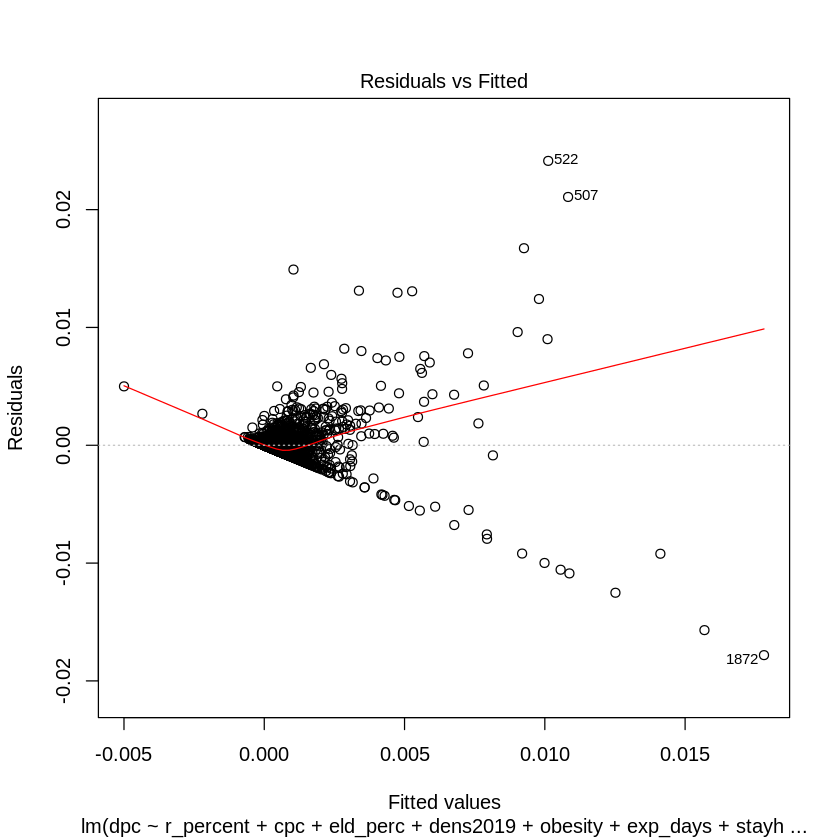

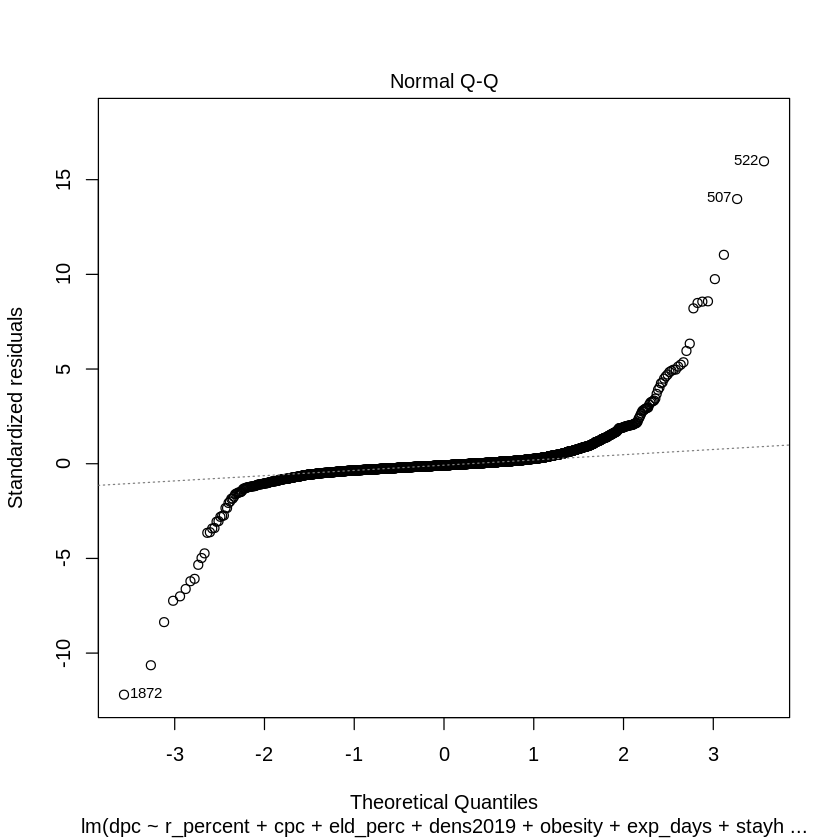

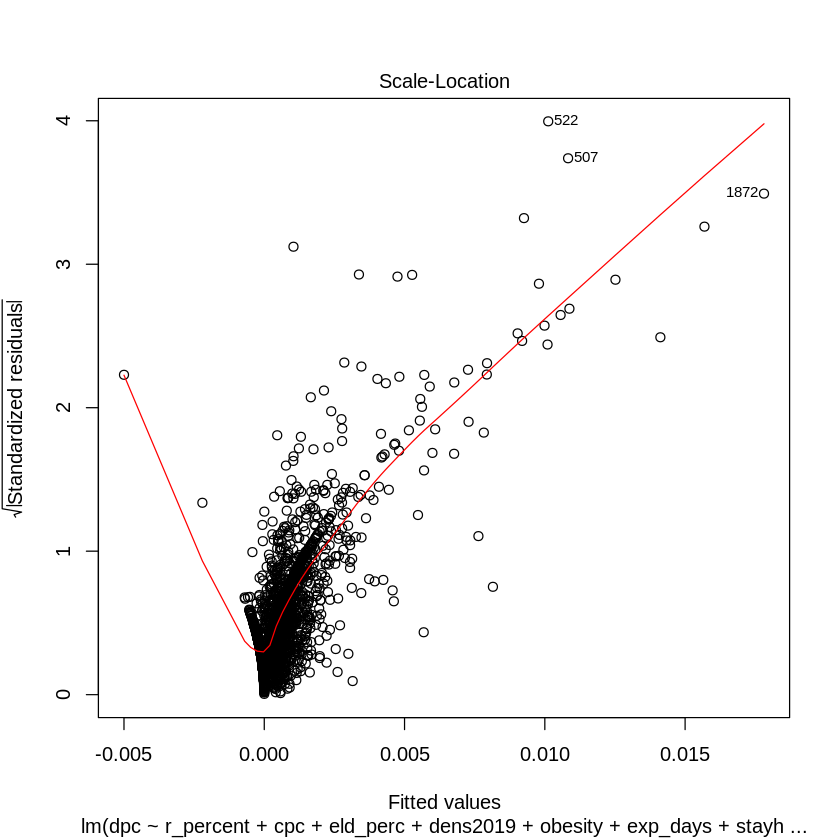

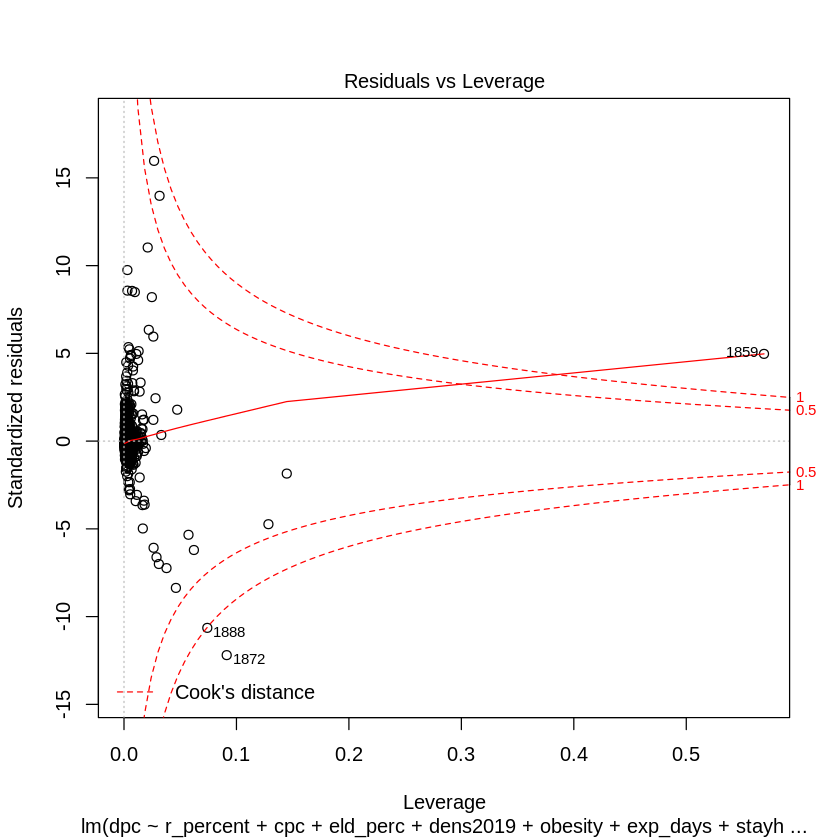

In [238]:
plot(d1)

In [36]:
# Model 5A
d1a <- lm(dpc ~ r_percent + cpc + eld_perc + dens2019 + obesity + exp_days + stayhome_issued + since_first,  data = df[df$deaths >= 1,])
summary(d1a)

vif(d1a)


Call:
lm(formula = dpc ~ r_percent + cpc + eld_perc + dens2019 + obesity + 
    exp_days + stayhome_issued + since_first, data = df[df$deaths >= 
    1, ])

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0197226 -0.0004866 -0.0000860  0.0003301  0.0174651 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -2.732e-03  6.376e-04  -4.285 1.97e-05 ***
r_percent        4.500e-06  3.529e-06   1.275 0.202528    
cpc              4.525e-02  1.042e-03  43.425  < 2e-16 ***
eld_perc         4.191e-03  1.156e-03   3.624 0.000302 ***
dens2019        -1.540e-07  5.270e-08  -2.922 0.003536 ** 
obesity          4.742e-03  1.206e-03   3.934 8.82e-05 ***
exp_days        -1.270e-05  8.804e-06  -1.443 0.149380    
stayhome_issued -8.121e-05  2.893e-04  -0.281 0.778965    
since_first      1.472e-05  9.867e-06   1.492 0.135910    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001638 on 1235 degr

r_percent             cpc        eld_perc        dens2019         obesity 
       1.392988        1.117129        1.110773        1.387483        1.266958 
       exp_days stayhome_issued     since_first 
       4.806223        3.125469        3.770578

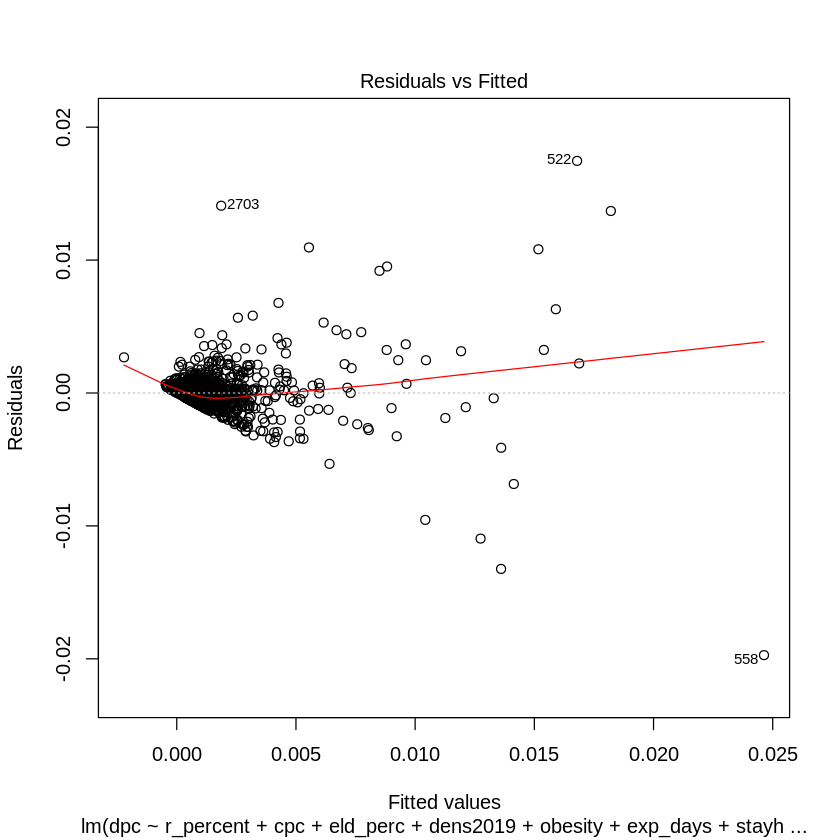

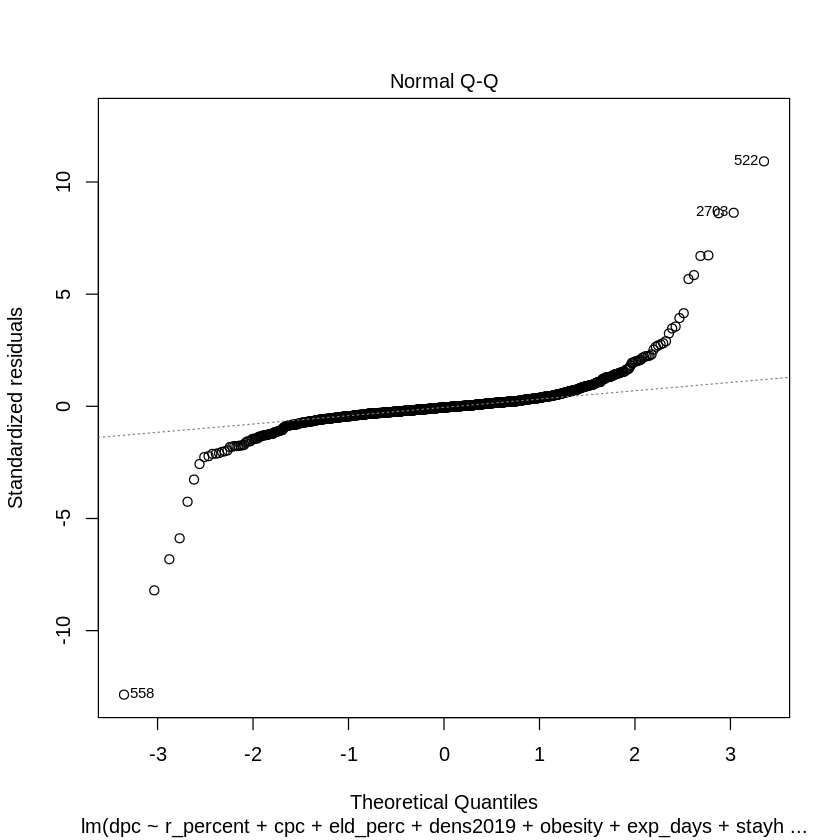

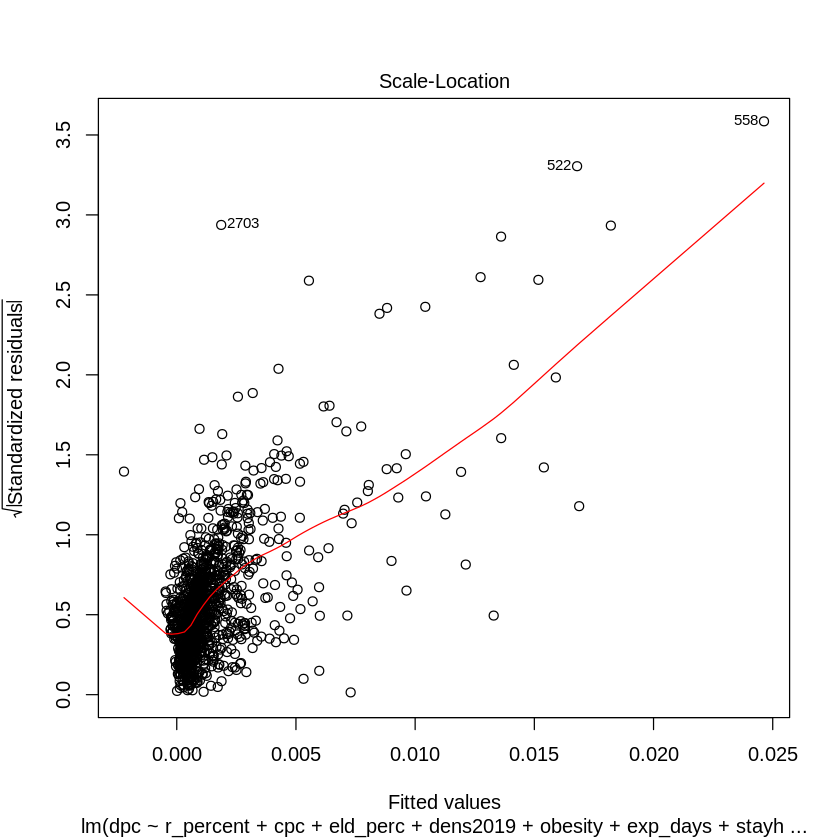

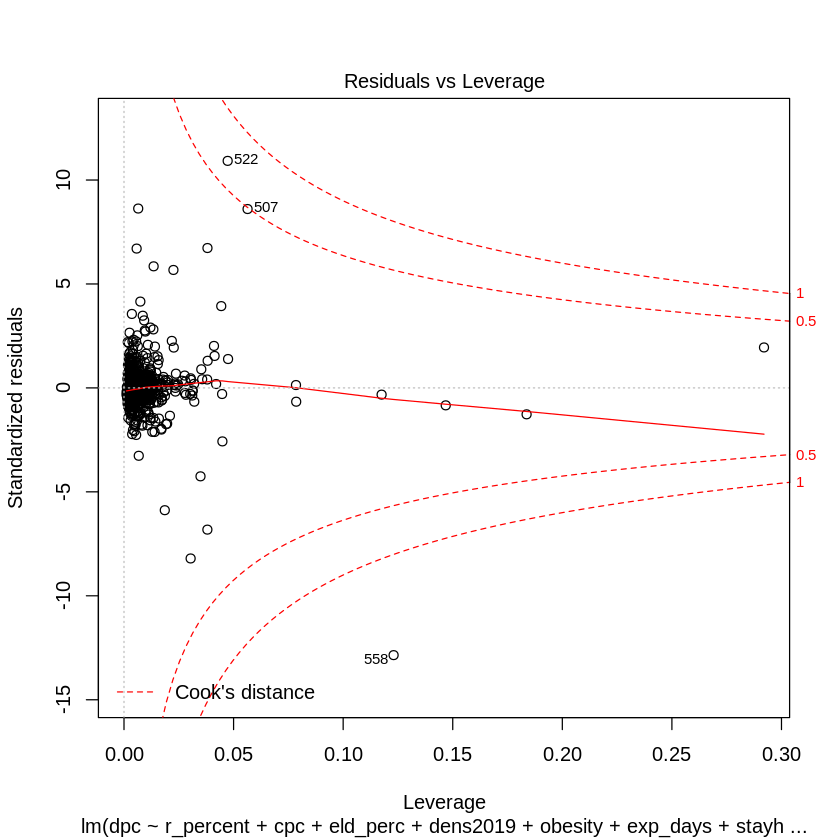

In [244]:
plot(d1a)

In [66]:
# Model 6
d2 <- lm(log(deaths+ .000001) ~ r_percent + log(cases + .000001) + log(over652018) + log(pop2018) + obesity + exp_days + stayhome_issued + since_first,  data = df[df$deaths >= 0,])
summary(d2)

vif(d2)


Call:
lm(formula = sqrt(deaths + 1e-06) ~ r_percent + sqrt(cases + 
    1e-06) + sqrt(over652018) + sqrt(pop2018) + obesity + exp_days + 
    stayhome_issued + since_first, data = df[df$deaths >= 0, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-86.318  -2.281  -0.354   1.694  89.368 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -9.670572   1.466512  -6.594 5.11e-11 ***
r_percent           -0.013844   0.010669  -1.298 0.194542    
sqrt(cases + 1e-06)  0.063422   0.003193  19.865  < 2e-16 ***
sqrt(over652018)     0.034125   0.009585   3.560 0.000377 ***
sqrt(pop2018)        0.003207   0.003693   0.868 0.385338    
obesity             23.310926   3.423264   6.810 1.20e-11 ***
exp_days            -0.023100   0.027306  -0.846 0.397638    
stayhome_issued     -0.137678   0.771011  -0.179 0.858290    
since_first          0.056851   0.024008   2.368 0.017955 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ 

r_percent sqrt(cases + 1e-06)    sqrt(over652018)       sqrt(pop2018) 
           1.396488            2.482034           38.463567           39.158262 
            obesity            exp_days     stayhome_issued         since_first 
           1.159052            5.226310            4.041612            3.572504

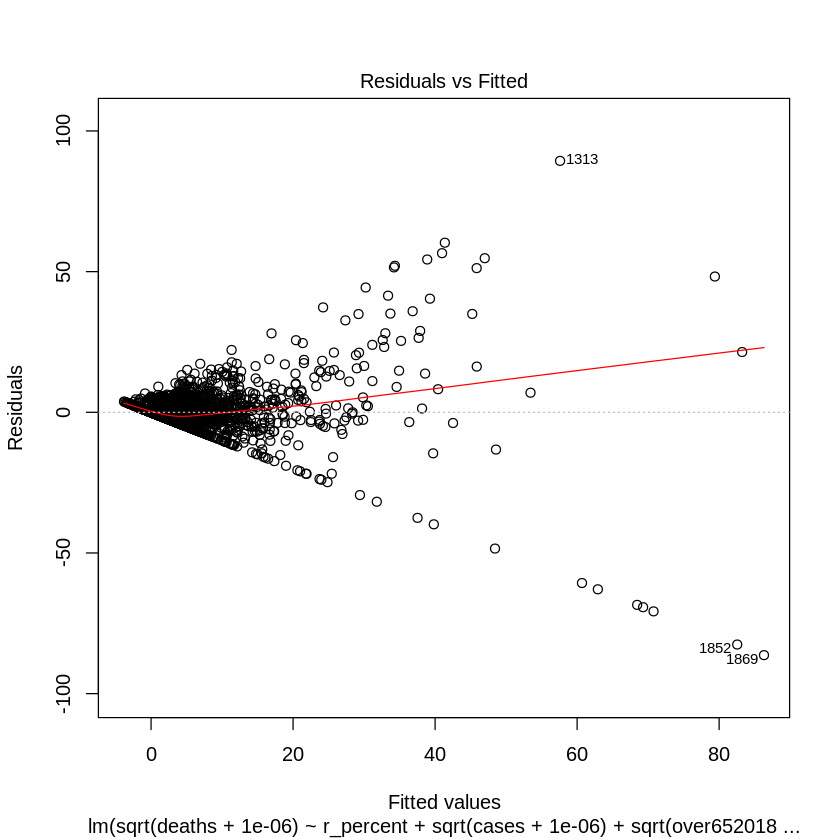

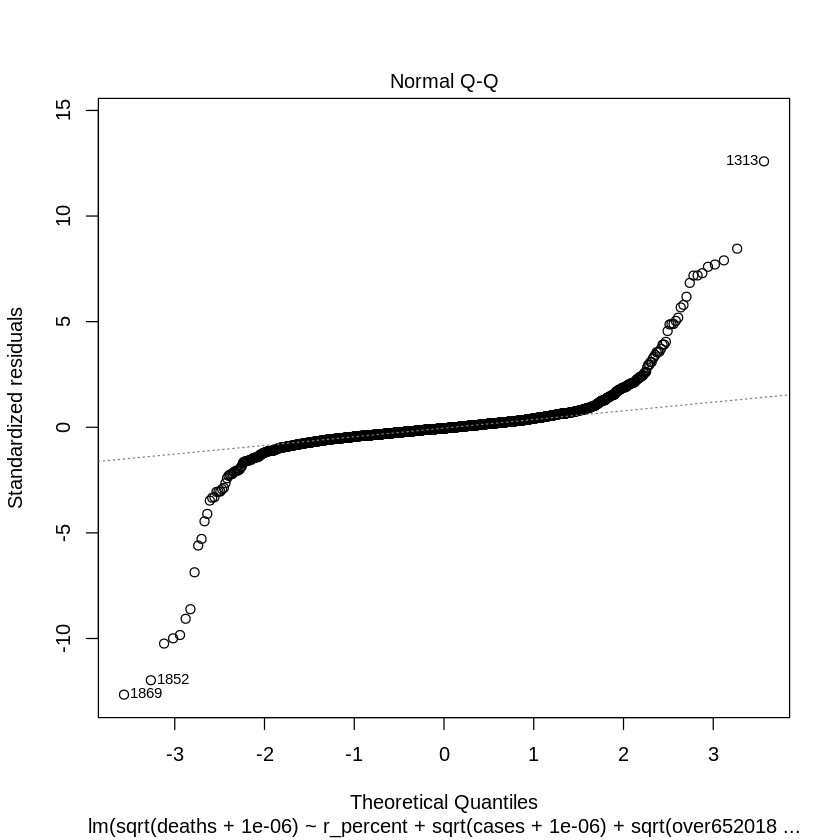

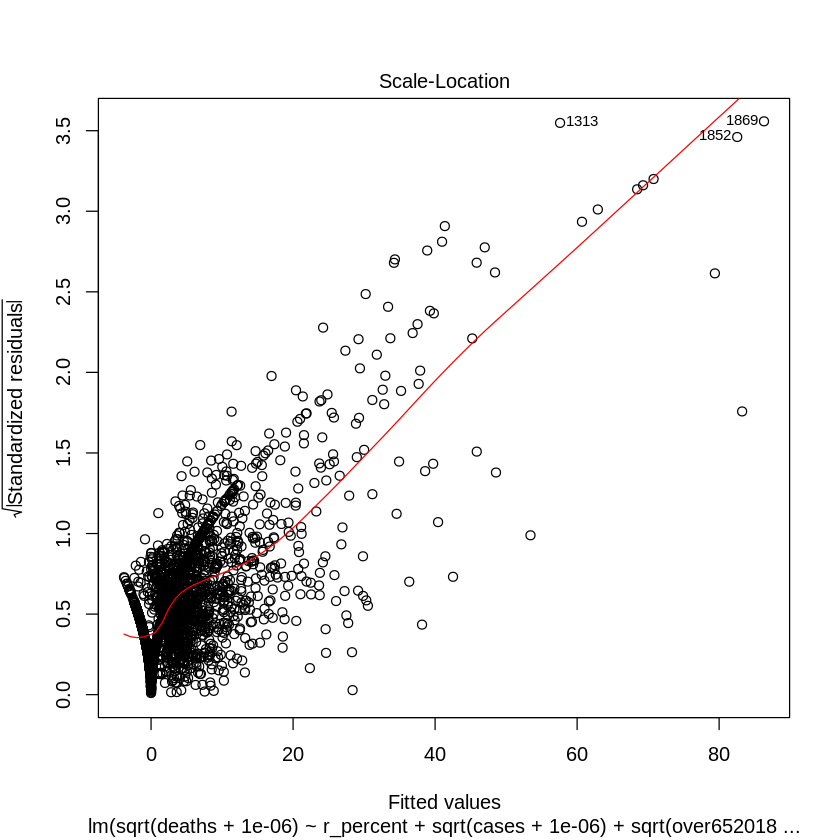

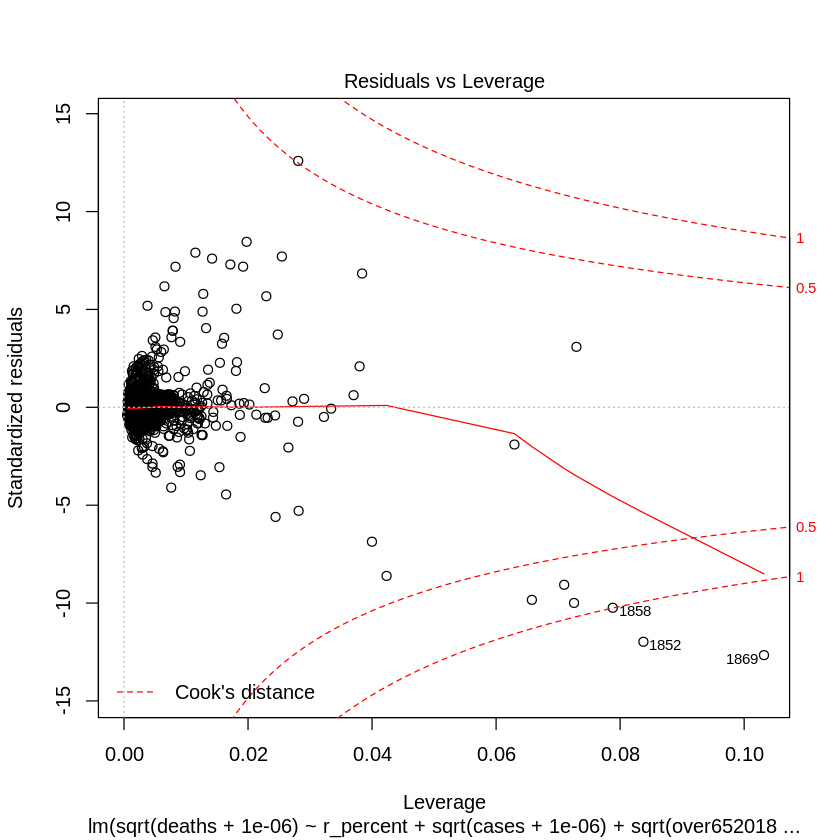

In [67]:
plot(d2)

In [32]:
# Model 6A
d2a <- lm(log(deaths+ .000001) ~ r_percent + log(cases + .000001) + log(over652018) + log(pop2018) + obesity + exp_days + stayhome_issued + since_first,  data = df[df$deaths >= 1,])
summary(d2a)

vif(d2a)


Call:
lm(formula = log(deaths + 1e-06) ~ r_percent + log(cases + 1e-06) + 
    log(over652018) + log(pop2018) + obesity + exp_days + stayhome_issued + 
    since_first, data = df[df$deaths >= 1, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9568 -0.4686  0.2246  0.6941  3.0438 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -2.327188   0.555877  -4.187 3.03e-05 ***
r_percent           0.004263   0.002343   1.819   0.0691 .  
log(cases + 1e-06)  0.845191   0.034457  24.529  < 2e-16 ***
log(over652018)     0.693821   0.152356   4.554 5.78e-06 ***
log(pop2018)       -0.692974   0.148170  -4.677 3.23e-06 ***
obesity             1.365351   0.822004   1.661   0.0970 .  
exp_days           -0.009833   0.005764  -1.706   0.0883 .  
stayhome_issued     0.040529   0.189254   0.214   0.8305    
since_first         0.017154   0.007043   2.436   0.0150 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual stand

r_percent log(cases + 1e-06)    log(over652018)       log(pop2018) 
          1.427901           3.770616          39.250405          41.835196 
           obesity           exp_days    stayhome_issued        since_first 
          1.367205           4.791579           3.105121           4.466781

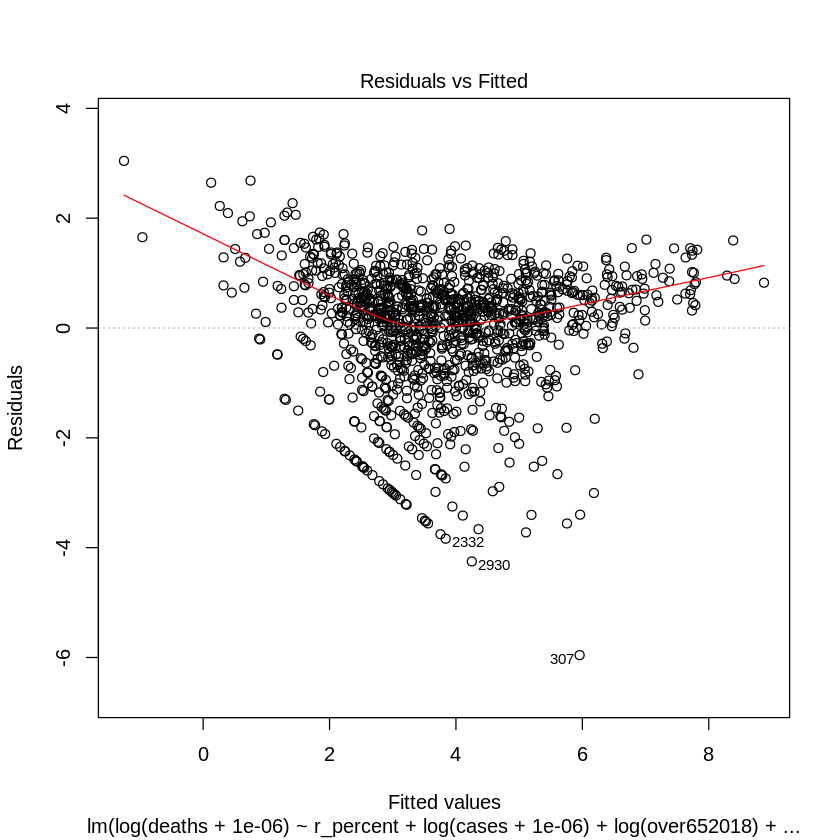

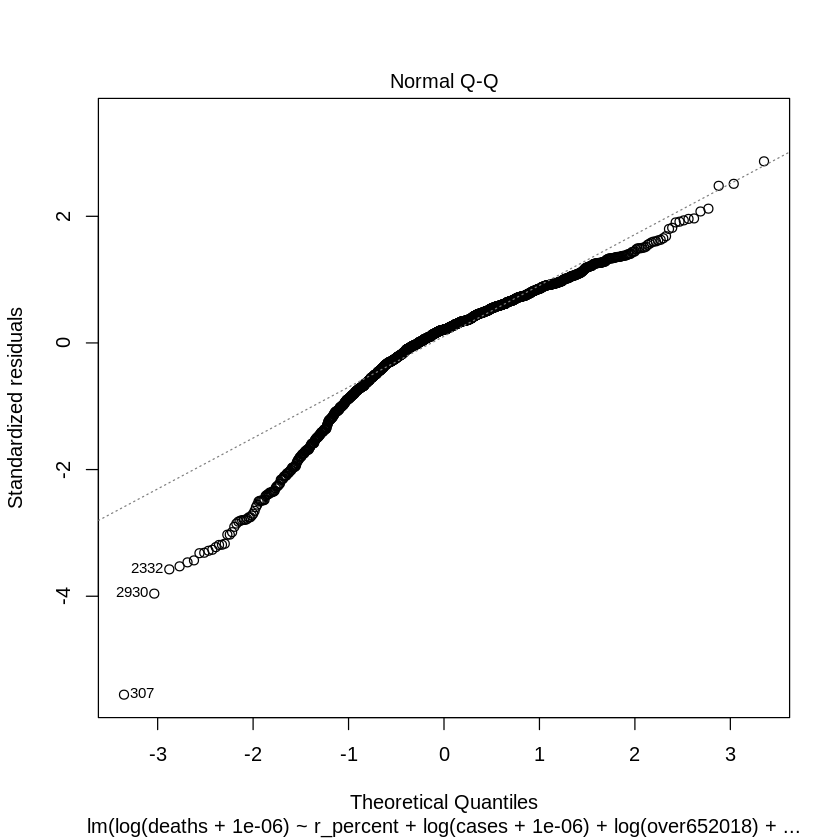

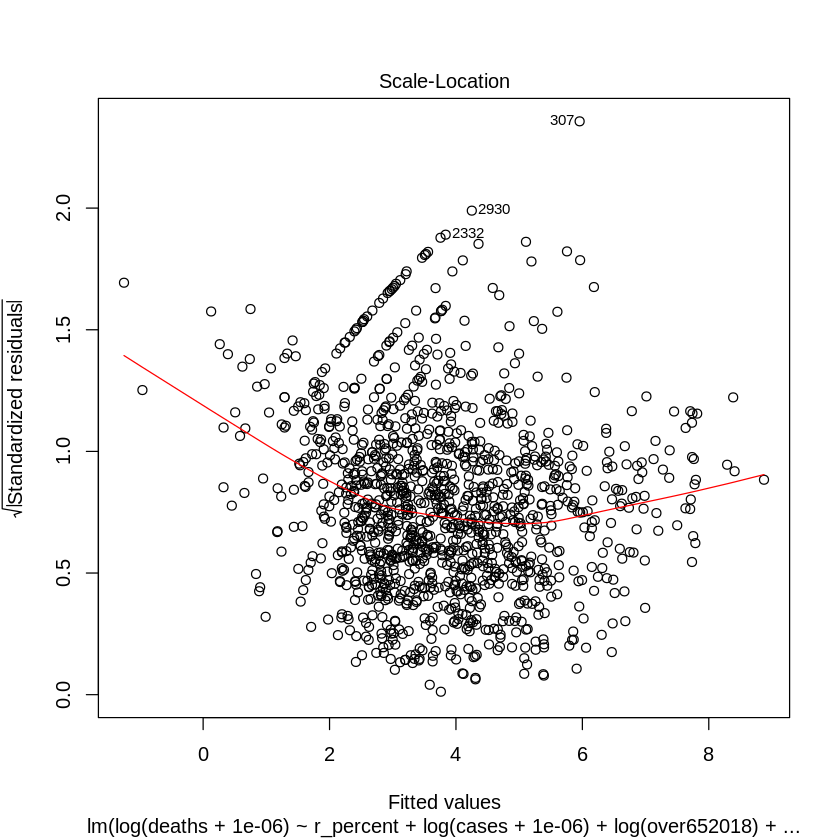

NULL

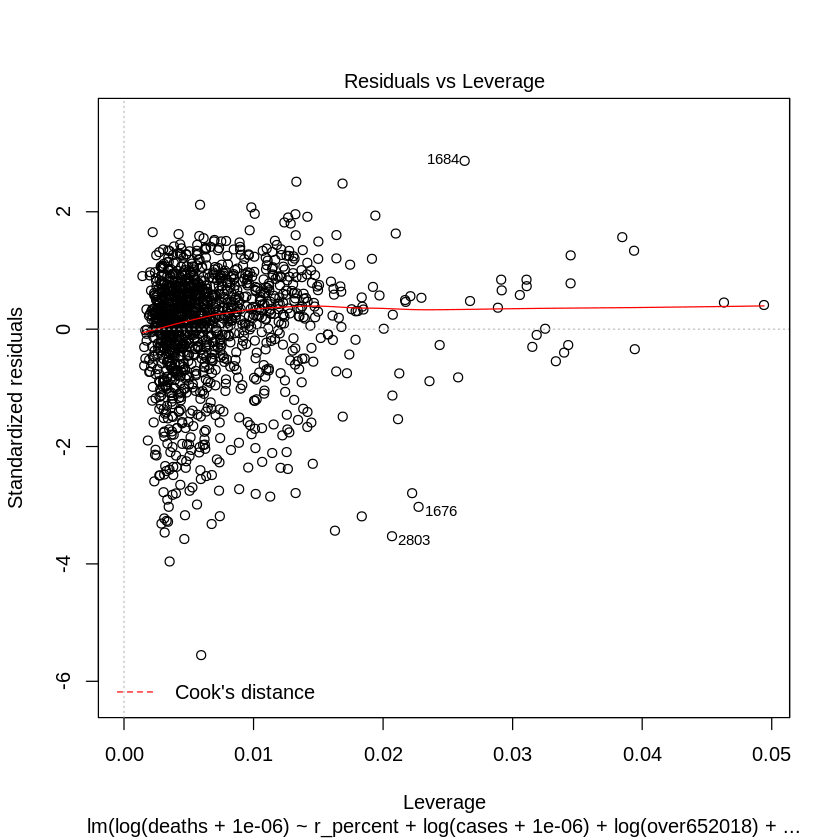

In [247]:
plot(d2a)

In [259]:
# H3 Regression Table
stargazer(d1, d1a, d2, d2a, type = 'latex', title = 'H3 Linear Regression',
          dep.var.labels = c('Deaths (Perc. of Pop.)', 'log(Total Deaths)'),
          column.labels = c('Model 5', 'Model 5A', 'Model 6', 'Model 6A'),
          covariate.labels = c('R Vote Perc.', 'Perc. Infected', 'Perc. Over 65', 'Pop. Density', 'log(Cases)', 'log(Over 65)', 'log(Pop)', 'Obesity', 'Exposure Days', 'Stayhome Orders', 'Days Since First Case', 'Constant'),
          no.space = FALSE,
          omit.stat=c('f'))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, May 04, 2020 - 10:19:26 PM
\begin{table}[!htbp] \centering 
  \caption{H3 Linear Regression} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lcccc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{4}{c}{\textit{Dependent variable:}} \\ 
\cline{2-5} 
\\[-1.8ex] & \multicolumn{2}{c}{Deaths (Perc. of Pop.)} & \multicolumn{2}{c}{log(Total Deaths)} \\ 
 & Model 5 & Model 5A & Model6 & Model6A \\ 
\\[-1.8ex] & (1) & (2) & (3) & (4)\\ 
\hline \\[-1.8ex] 
 R Vote Perc. & $-$0.00000$^{**}$ & 0.00000 & 0.016 & 0.004$^{*}$ \\ 
  & (0.00000) & (0.00000) & (0.010) & (0.002) \\ 
  & & & & \\ 
 Perc. Infected & 0.026$^{***}$ & 0.045$^{***}$ &  &  \\ 
  & (0.001) & (0.001) &  &  \\ 
  & & & & \\ 
 Perc. Over 65 & 0.001$^{*}$ & 0.004$^{***}$ &  &  \\ 
  & (0.001) & (0.001) &  &  \\ 
  & & & & \\ 
 Pop. Density & $-$0.00000$^{***}$ & $-$0.00000$^{***}$ &  &  \\ 
  & (0

In [33]:
# Residual and quantile plots for H3
png(file="./plots/d2_resid.png",
width=350, height=350)
plot(d2, which = 1)
dev.off()

png(file="./plots/d2_qq.png",
width=350, height=350)
plot(d2, which = 2)
dev.off()

png(file="./plots/d2a_resid.png",
width=350, height=350)
plot(d2a, which = 1)
dev.off()

png(file="./plots/d2a_qq.png",
width=350, height=350)
plot(d2a, which = 2)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

# Correlation matrix

In [288]:
# correlations. Very strong negative correlation with days since first case and r_percent. strong positive with exp days and r_percent
cormat <- cor(df[,c(11, 3, 4, 5, 6, 8, 16, 17, 19, 20, 26)], use = 'complete.obs')

names <- c('R vote%', 'Pop.', 'Elderly Pop.', 'Pop. Dens.', 'Cases', 'Deaths', 'obesity', 'Exp Days', 'Death %', 'Infected %', 'Stayhome Issued')
colnames(cormat) <- names
rownames(cormat) <- names

stargazer(cormat)

# Plots & exploration

In [5]:
# prep data for plot
first <- df[complete.cases(df[,c('first_case', 'rmaj')]),]
first <- summarise(group_by(first, first_case, rmaj), r = sum(rmaj, na.rm = TRUE), d = sum(dmaj, na.rm = TRUE))
first$sum <- first$r + first$d

first <- first[,c('first_case', 'rmaj', 'sum')]
# color vector
first$color <- ifelse(first$rmaj == 1, 'R', 'D')

Saving 6.67 x 6.67 in image



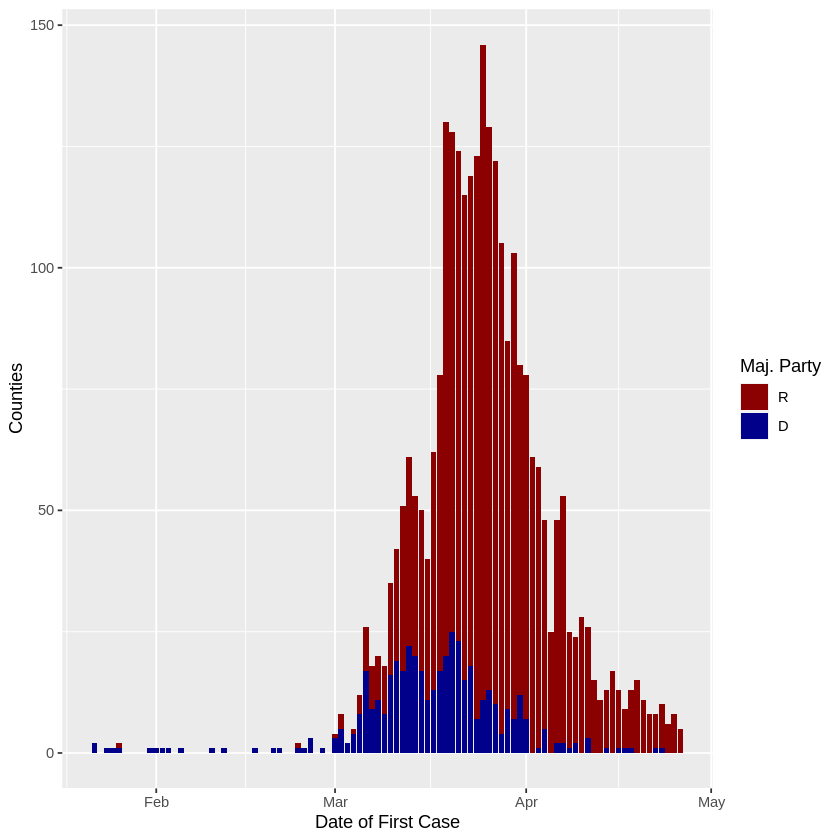

In [24]:
# distribution of first cases
ggplot(data = first, 
       aes(x = first_case, y = sum, fill = factor(color, levels = c('R', 'D')))) + 
  geom_bar(stat = 'sum', position = 'stack') + 
scale_fill_manual(values = c("dark red", "dark blue")) + 
guides(color = "legend", size = 'none') +  
labs(fill = "Maj. Party", x = 'Date of First Case', y = 'Counties')

ggsave('plots/first case dist.png')

Most republican counties had not even seen their first case by the time social distancing guidelines were implemented.

Guidelines to restrict travel and avoid gatherings of more than 10 issued march 16: https://www.usatoday.com/story/news/health/2020/03/16/coronavirus-live-updates-us-death-toll-rises-cases-testing/5053816002/

In [81]:
# average date of first case for majority republican
mean.Date(df[df$rmaj == 1, 'first_case'], na.rm = TRUE)

[1] "2020-03-26"

In [82]:
# average date of first case for majority dem
mean.Date(df[df$rmaj == 0, 'first_case'], na.rm = TRUE)

[1] "2020-03-16"

In [246]:
# difference of means test for when first case was by party
t.test(yday(df[df$rmaj == 1, 'first_case']), yday(df[df$rmaj == 0, 'first_case']))


	Welch Two Sample t-test

data:  yday(df[df$rmaj == 1, "first_case"]) and yday(df[df$rmaj == 0, "first_case"])
t = 16.534, df = 551.57, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  8.997107 11.423035
sample estimates:
mean of x mean of y 
 86.76763  76.55756 
